In [2]:
from matplotlib import patches
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from scipy import signal
from scipy.signal import find_peaks
import pywt
from scipy.signal import butter, filtfilt
from scipy.signal import czt
from scipy.optimize import least_squares
from scipy.signal import spectrogram

In [3]:
#read data
file_path = './FMCW Radar/Rawdata/Rawdata_1.csv'
def readCsv(pathFile):
    arrays = []

    with open(pathFile, 'r') as file:
        # Read the lines of the file
        lines = file.readlines()
        for line in lines:
            line_values = line.strip().split(',')
            arrays.append(line_values)
    complex_array = []
    for array in arrays:

        complex_value = np.array(
            [complex(element.replace('i', 'j')) for element in array])
        complex_array.append(complex_value)
    np.array(complex_array)
    return np.array(complex_array)
raw_data = readCsv(file_path)
raw_data_channel_0 = raw_data[0]


In [4]:
T_c = 91.72 * (1e-6)   # Chirp time
f_start = 60.25*(1e9)  # Hz
NUM_SAMPLE_CHIRP = 256
SAMPLING_RATE = 3000000
B =3.75 * (1e9) #bandwidth
# Calculate frequency variation
wavelength=3.947
RANGE_RESOLUTION=4 # 4cm
MAX_RANGE=1100#11 m = 1100 cm
speed_of_light = 299792458

![Screenshot 2023-11-03 at 1.12.06 PM.png](<attachment:Screenshot 2023-11-03 at 1.12.06 PM.png>)
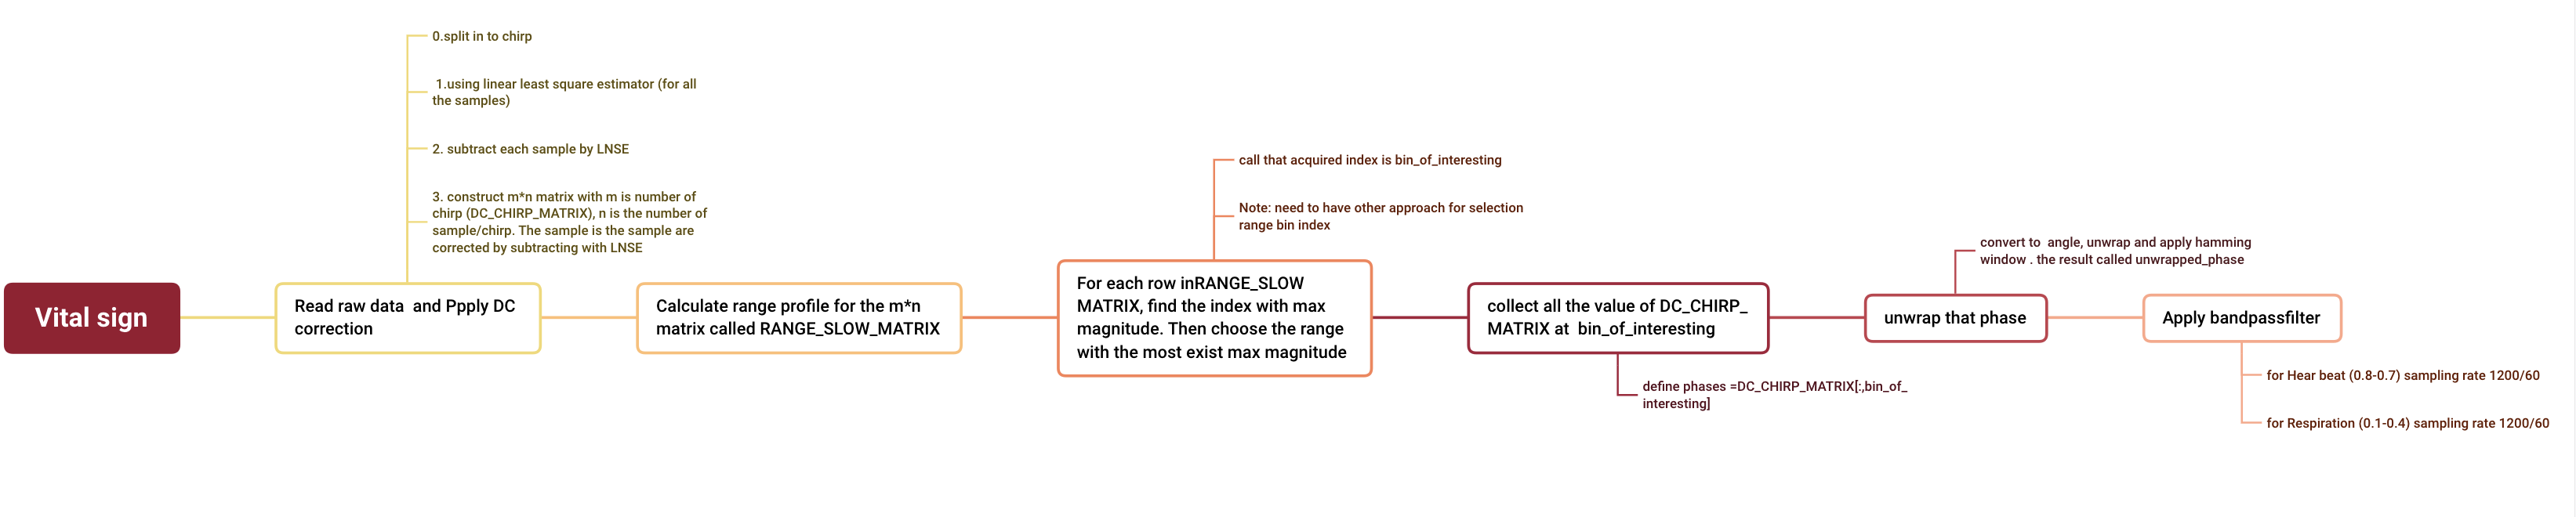

In [5]:
print(len(raw_data_channel_0))
chirps = [raw_data_channel_0[i:i+NUM_SAMPLE_CHIRP*2] for i in range(0, len(raw_data_channel_0), NUM_SAMPLE_CHIRP*2)]
first_chirps_of_frame = [chirps[j] for j in range(0, len(chirps), 1)]
print(np.array(first_chirps_of_frame).shape)


3072000
(6000, 512)


In [6]:
def residuals(params, x1, x2):
    a, b, c = params
    return (x1 - a)**2 + (x2 - b)**2 - c

initial_params=np.array([0.5,0.5,0.5])
real_parts = []
imag_parts = []
IFchirps = np.array(first_chirps_of_frame).flatten()
for IFchirp in IFchirps:
    real_parts.append(IFchirp.real)
    imag_parts.append(IFchirp.imag)
r_result = least_squares(residuals, initial_params, args=(np.array(real_parts).flatten(), (np.array(imag_parts).flatten())))


In [7]:
a,b,c =r_result.x
DC_compensation =a+b*1j 
DC_corrected_chirps = [ (first_chirp -DC_compensation) for first_chirp in first_chirps_of_frame]

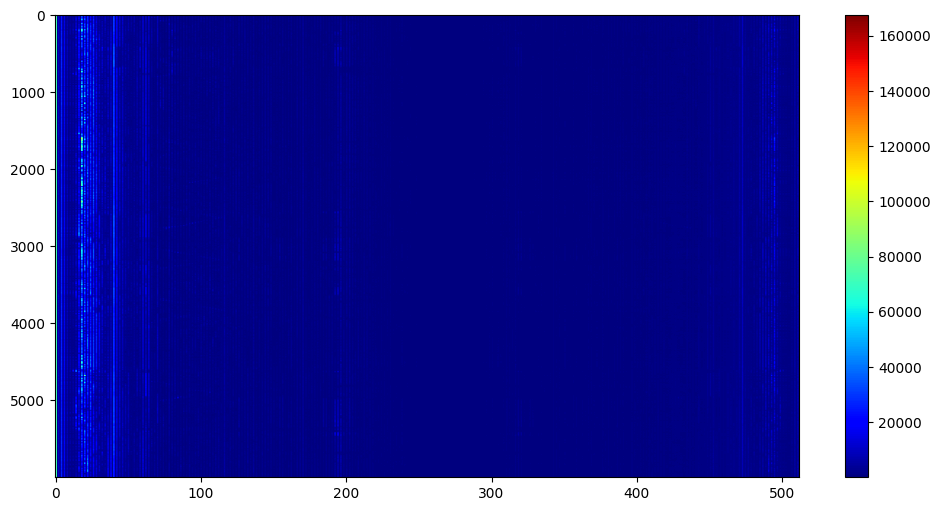

In [8]:
chirps_range_profiles = [np.fft.fft(chirp) for chirp in first_chirps_of_frame]
chirp_magnitudes = [np.abs(range_profile) for range_profile in chirps_range_profiles]

plt.figure(figsize=(12, 6))
plt.imshow(chirp_magnitudes,aspect='auto',cmap='jet')
plt.colorbar()
plt.show()

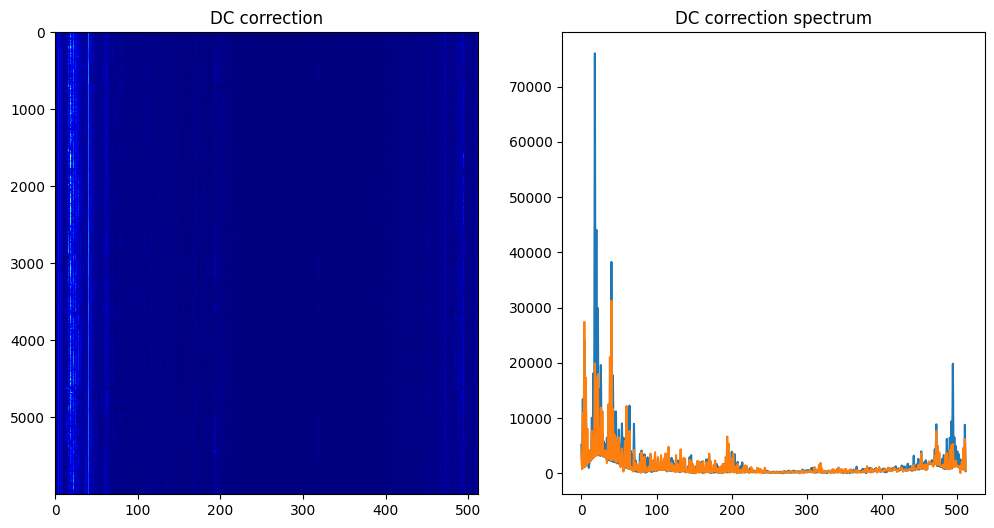

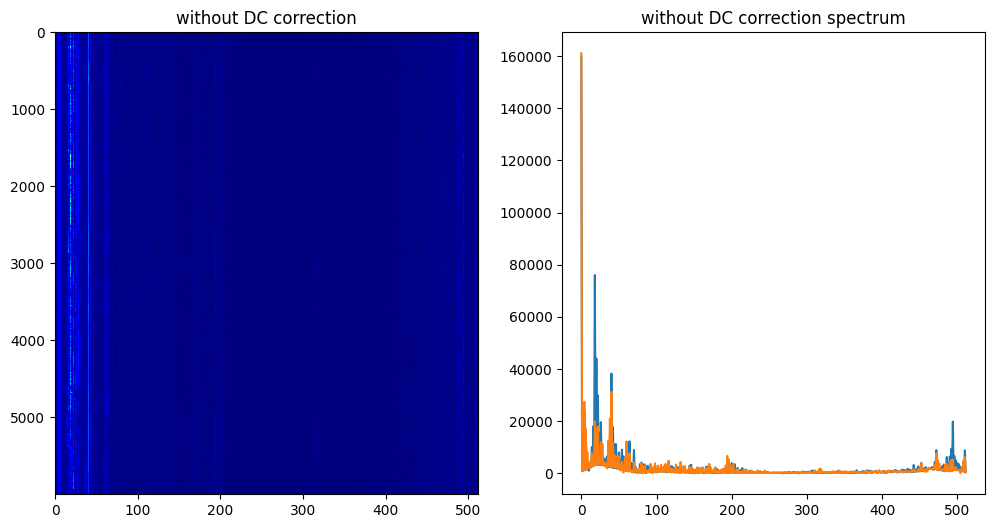

In [9]:
DC_corrected_chirps_range_profile = [np.fft.fft(DC_corrected_chirp) for DC_corrected_chirp in DC_corrected_chirps]
DC_corrected_magnitude = [np.abs(DC_corrected_chirps_fft) for DC_corrected_chirps_fft in DC_corrected_chirps_range_profile]


fft_chirps =[np.fft.fft(chirp) for chirp in first_chirps_of_frame]
abs_chirps =[np.abs(np.fft.fft(chirp)) for chirp in first_chirps_of_frame]

fig, axes= plt.subplots(nrows=1,ncols=2,figsize=(12, 6)) 
axes[0].imshow(np.array(DC_corrected_magnitude),aspect='auto',cmap='jet')
axes[0].set_title("DC correction")
axes[1].plot(DC_corrected_magnitude[0])
axes[1].plot(DC_corrected_magnitude[-1])
axes[1].set_title("DC correction spectrum")

fig, axes_tmp= plt.subplots(nrows=1,ncols=2,figsize=(12, 6)) 
axes_tmp[0].imshow(np.array(abs_chirps),cmap='jet',aspect='auto')
axes_tmp[0].set_title("without DC correction")
axes_tmp[1].plot(chirp_magnitudes[0])
axes_tmp[1].plot(chirp_magnitudes[-1])
axes_tmp[1].set_title("without DC correction spectrum")

plt.show()

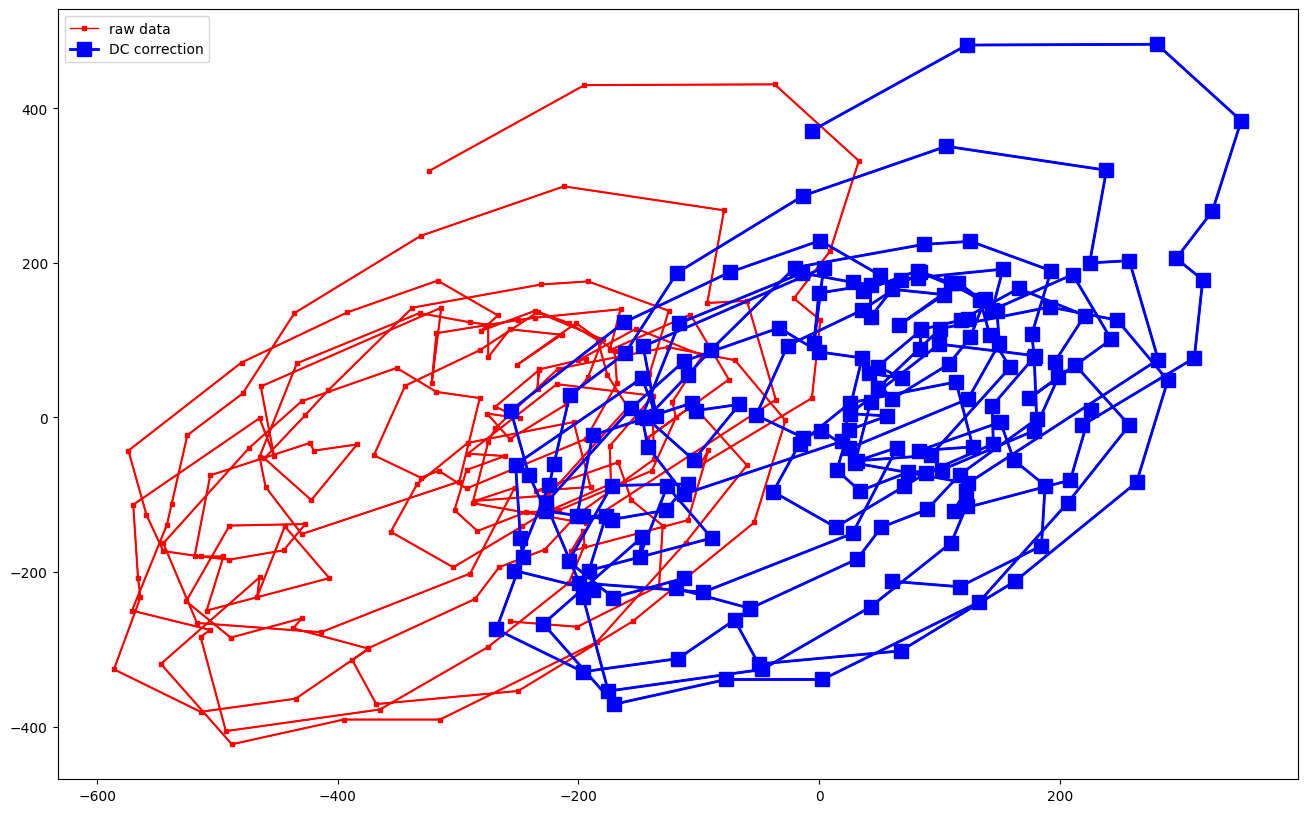

In [10]:

raw_chirps = (np.array(first_chirps_of_frame).flatten())[0:200]
raw_chirps_real = [raw_chirp.real for raw_chirp in raw_chirps]
raw_chirps_image = [raw_chirp.imag for raw_chirp in raw_chirps]

dc_chirps  =(np.array(DC_corrected_chirps).flatten()) [0:200]
DC_corrected_real = [dc_chirp.real for dc_chirp in dc_chirps]
DC_corrected_image =[dc_chirp.imag for dc_chirp in dc_chirps]

plt.figure(figsize=(16, 10))

plt.plot(raw_chirps_real, raw_chirps_image, 'rs-', markeredgewidth=1, markersize=3,linewidth=-1,label='raw data')
plt.plot(raw_chirps_real, raw_chirps_image, color='red')

plt.plot(DC_corrected_real, DC_corrected_image, 'bs-', markeredgewidth=1, markersize=10,linewidth=2,label='DC correction')
plt.plot(DC_corrected_real, DC_corrected_image, color='blue')
plt.legend()
plt.show()


In [11]:
magnitude_index = np.zeros(shape=len(DC_corrected_magnitude))
for  magnitude_spectrum in DC_corrected_magnitude:
    magnitude = np.abs(magnitude_spectrum)
    max_index=np.argmax(magnitude_spectrum[0:-1])
    # max_value = max(magnitude[1:-1])
    # max_index = np.where(max_value == magnitude)[0]
    magnitude_index[max_index]+=1
max_bin = max(magnitude_index)
bin_of_interest = np.where(max_bin ==magnitude_index )[0]

# for i,val in enumerate(magnitude_index):
#     if(0!=val):
#         print("index:",i," : ",val)
print("bin of interest: NEED TO CONSIDER AGAIN",bin_of_interest)

bin of interest: NEED TO CONSIDER AGAIN [18]


In [12]:
interested_bin_phase =np.array(DC_corrected_chirps)[:,bin_of_interest]

In [13]:
# try to apply DACM on interested_bin_phase
#I :real
#Q :imagine
def get_phase_DACM(interesting_phase):
    
    phase_len =len(interesting_phase)
    phase_DACM = np.zeros(shape=(np.array(interesting_phase).shape),dtype=float)
    phase_DACM[0]=np.angle(interesting_phase[0])
    phase_DACM[1]=np.angle(interesting_phase[1])
    for i in range(2,phase_len):
        I_k=interesting_phase[i].real
        Q_k=interesting_phase[i].imag

        I_k_prev=interesting_phase[i-1].real
        Q_k_prev=interesting_phase[i-1].imag
        
        phase_DACM[i]+= (I_k * (Q_k -Q_k_prev) -(I_k - I_k_prev)* Q_k)/(I_k*I_k + Q_k * Q_k)
    return phase_DACM

In [14]:
def filter_signal (signal_to_filter ,_low_freq,_high_freq,_sampling_rate,_filter_order):
    sampling_rate = _sampling_rate# Sampling rate of the input signal
    low_freq = _low_freq  # Lower cutoff frequency of the bandpass filter
    high_freq = _high_freq  # Upper cutoff frequency of the bandpass filter
    filter_order = _filter_order # Order of the bandpass filter

    # Compute the normalized cutoff frequencies
    nyquist_freq = 0.5 * sampling_rate
    low_norm = low_freq / nyquist_freq
    high_norm = high_freq / nyquist_freq
    
    # Design the bandpass filter
    b, a = signal.butter(filter_order, [low_norm, high_norm], btype='band')

    # Apply the bandpass filter to the input signal
    signal_filtered = signal.lfilter(b, a, signal_to_filter)
    return signal_filtered

In [15]:

DACM_phase  = get_phase_DACM(interested_bin_phase)
DACM_phase_difference = np.diff(np.array(DACM_phase).flatten())

DACM_phase_unwrapped =np.unwrap(DACM_phase)
DACM_phase_unwrapped_difference = np.diff(np.array(DACM_phase_unwrapped).flatten())

phase_difference = np.diff(np.array(interested_bin_phase).flatten())


/Users/truongdinh/Downloads/Children Dataset/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<Figure size 1200x600 with 0 Axes>

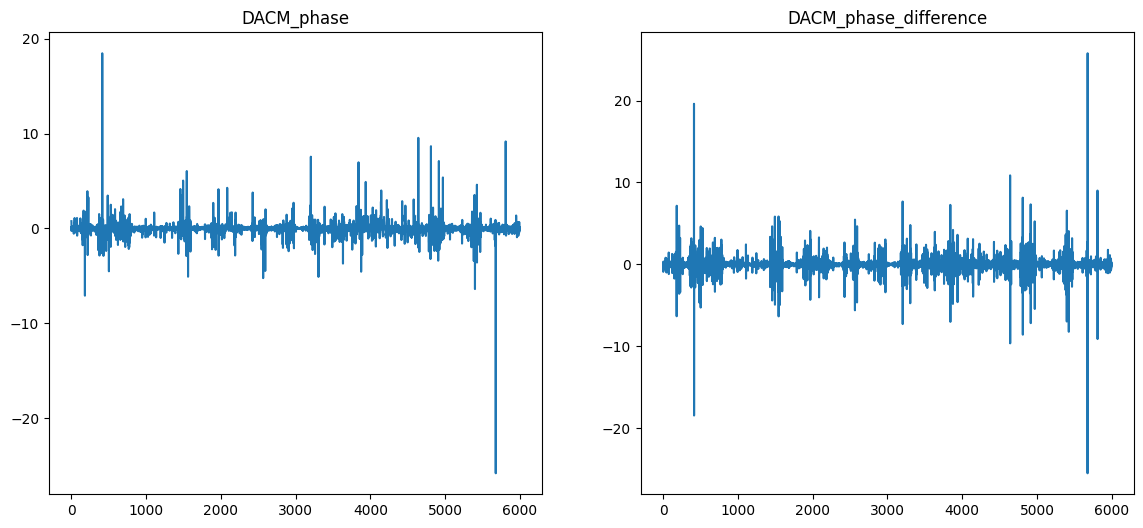

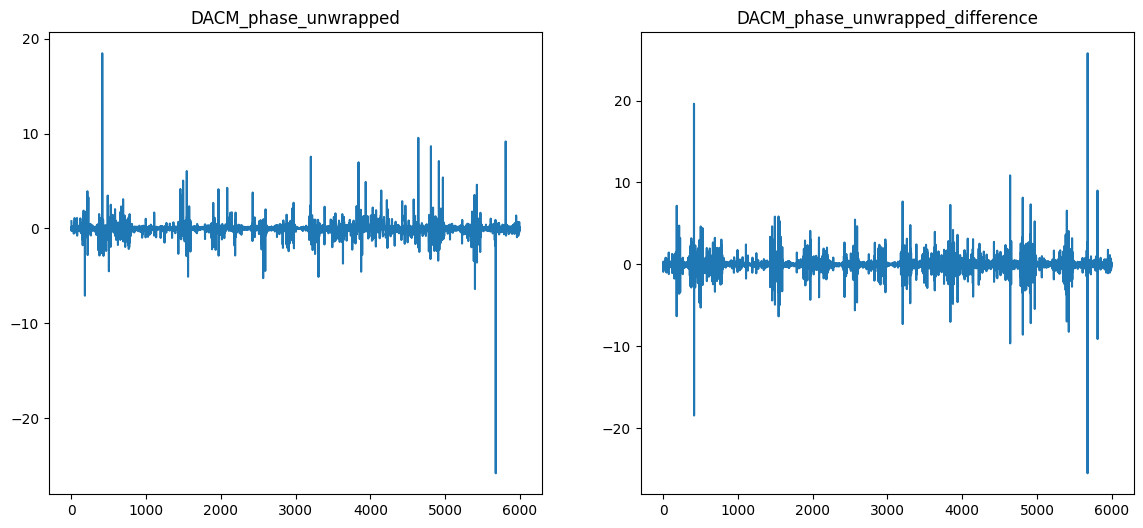

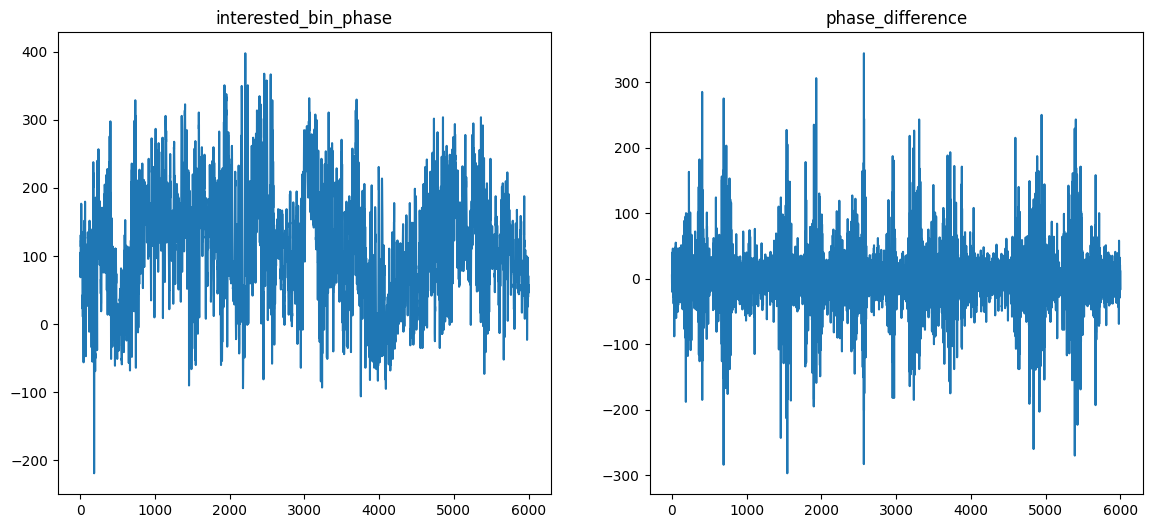

In [16]:
plt.figure(figsize=(12,6))

fig,axes = plt.subplots(ncols=2,nrows=1,figsize=(14,6) )
axes[0].plot(DACM_phase,label='DACM')
axes[0].set_title("DACM_phase")

axes[1].plot(DACM_phase_difference,label='Difference DACM')
axes[1].set_title("DACM_phase_difference")

fig,axes = plt.subplots(ncols=2,nrows=1,figsize=(14,6) )
axes[0].plot(DACM_phase_unwrapped,label='DACM unwrapping')
axes[0].set_title("DACM_phase_unwrapped")
axes[1].plot(DACM_phase_unwrapped_difference,label='Difference DACM unwrapping ')
axes[1].set_title("DACM_phase_unwrapped_difference")

fig,axes = plt.subplots(ncols=2,nrows=1,figsize=(14,6) )
axes[0].plot(interested_bin_phase,label='phase')
axes[0].set_title("interested_bin_phase")
axes[1].plot(phase_difference,label='Difference phase')
axes[1].set_title("phase_difference")

plt.show()

In [17]:
SR=1200/60
DCAM_phase_breath =filter_signal(DACM_phase,0.1,0.5,SR,4)
DCAM_phase_diff_breath =filter_signal(DACM_phase_difference,0.1,0.5,SR,4)
DCAM_phase_breath_unwrapped =filter_signal(DACM_phase_unwrapped,0.1,0.5,SR,4)
DCAM_phase_diff_breath_unwrapped =filter_signal(DACM_phase_unwrapped_difference,0.1,0.5,SR,4)
DCAM_phase_diff_breath_angle =np.angle(DCAM_phase_diff_breath)

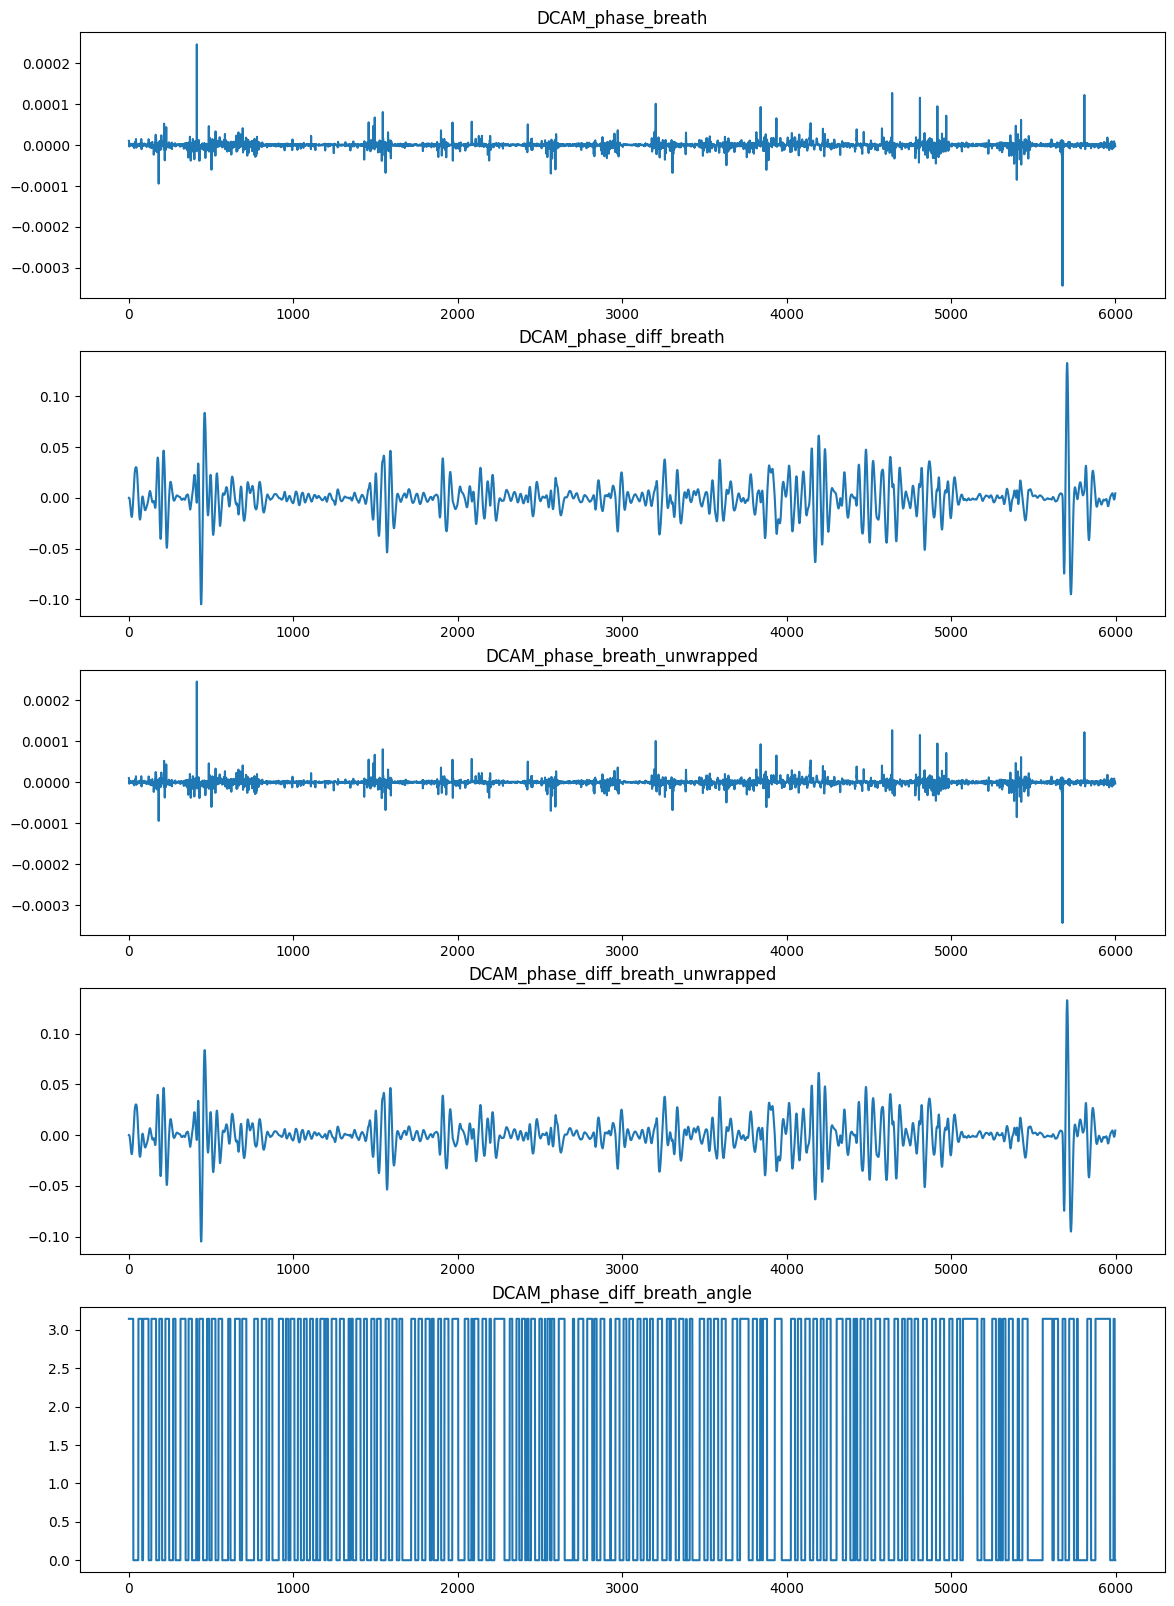

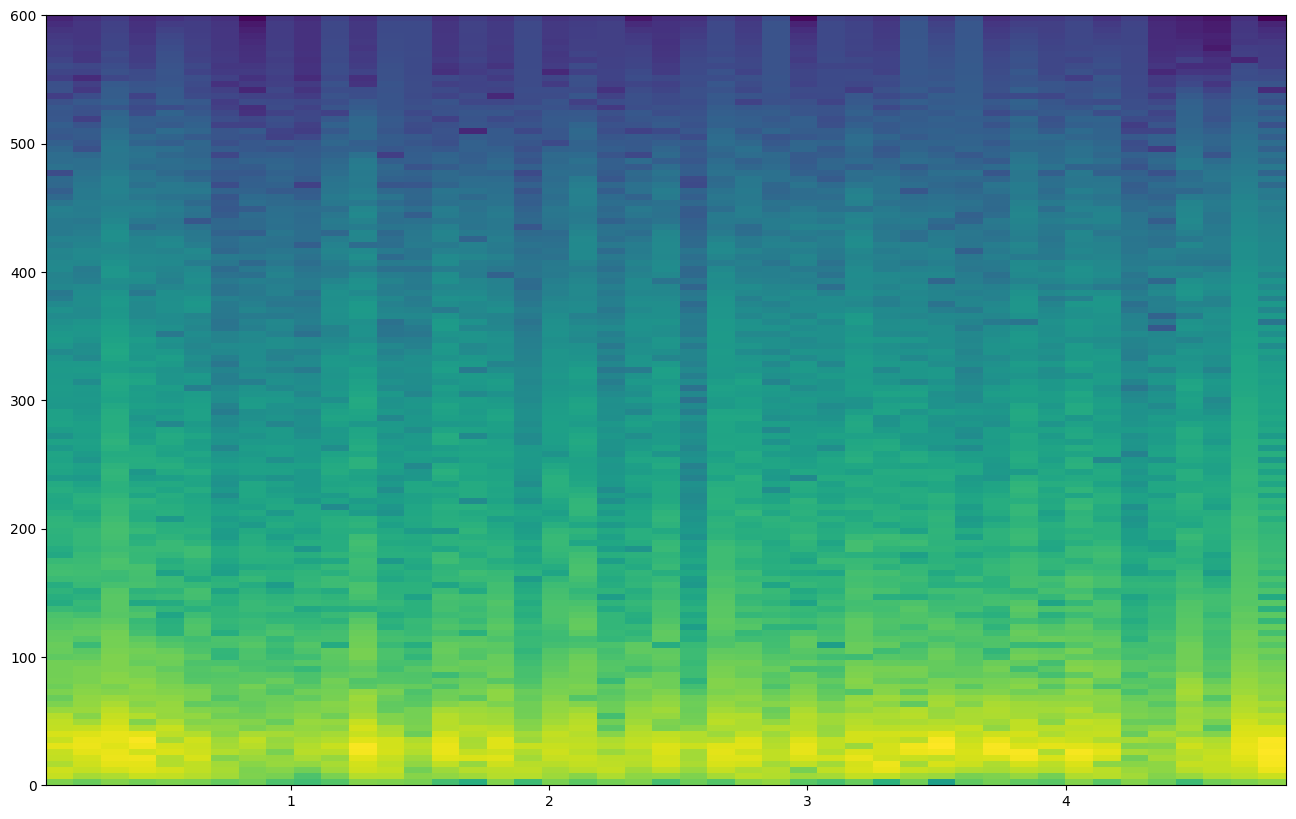

In [18]:

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(14, 20))  # 1 row, 2 columns
axes[0].set_title("DCAM_phase_breath")
axes[0].plot(DCAM_phase_breath,label ='DCAM_phase_breath')

axes[1].set_title("DCAM_phase_diff_breath")
axes[1].plot(DCAM_phase_diff_breath,label ='DCAM_phase_diff_breath')

axes[2].set_title("DCAM_phase_breath_unwrapped")
axes[2].plot(DCAM_phase_breath_unwrapped,label ='DCAM_phase_breath_unwrapped')

axes[3].set_title("DCAM_phase_diff_breath_unwrapped")
axes[3].plot(DCAM_phase_diff_breath_unwrapped,label ='DCAM_phase_diff_breath_unwrapped')

axes[4].set_title("DCAM_phase_diff_breath_angle")
axes[4].plot(DCAM_phase_diff_breath_angle,label ='DCAM_phase_diff_breath_angle')

plt.show()
plt.figure(figsize=(16, 10))
plt.specgram(DCAM_phase_diff_breath,Fs=1200)
plt.show()



In [24]:
DCAM_phase_heart =filter_signal(DACM_phase,0.8,2,SR,4)
DCAM_phase_diff_heart =filter_signal(DACM_phase_difference,0.8,2,SR,4)

DCAM_phase_heart_unwrapped =filter_signal(DACM_phase_unwrapped,0.8,2,SR,4)
DCAM_phase_diff_heart_unwrapped =filter_signal(DACM_phase_unwrapped_difference,0.3,2,SR,4)

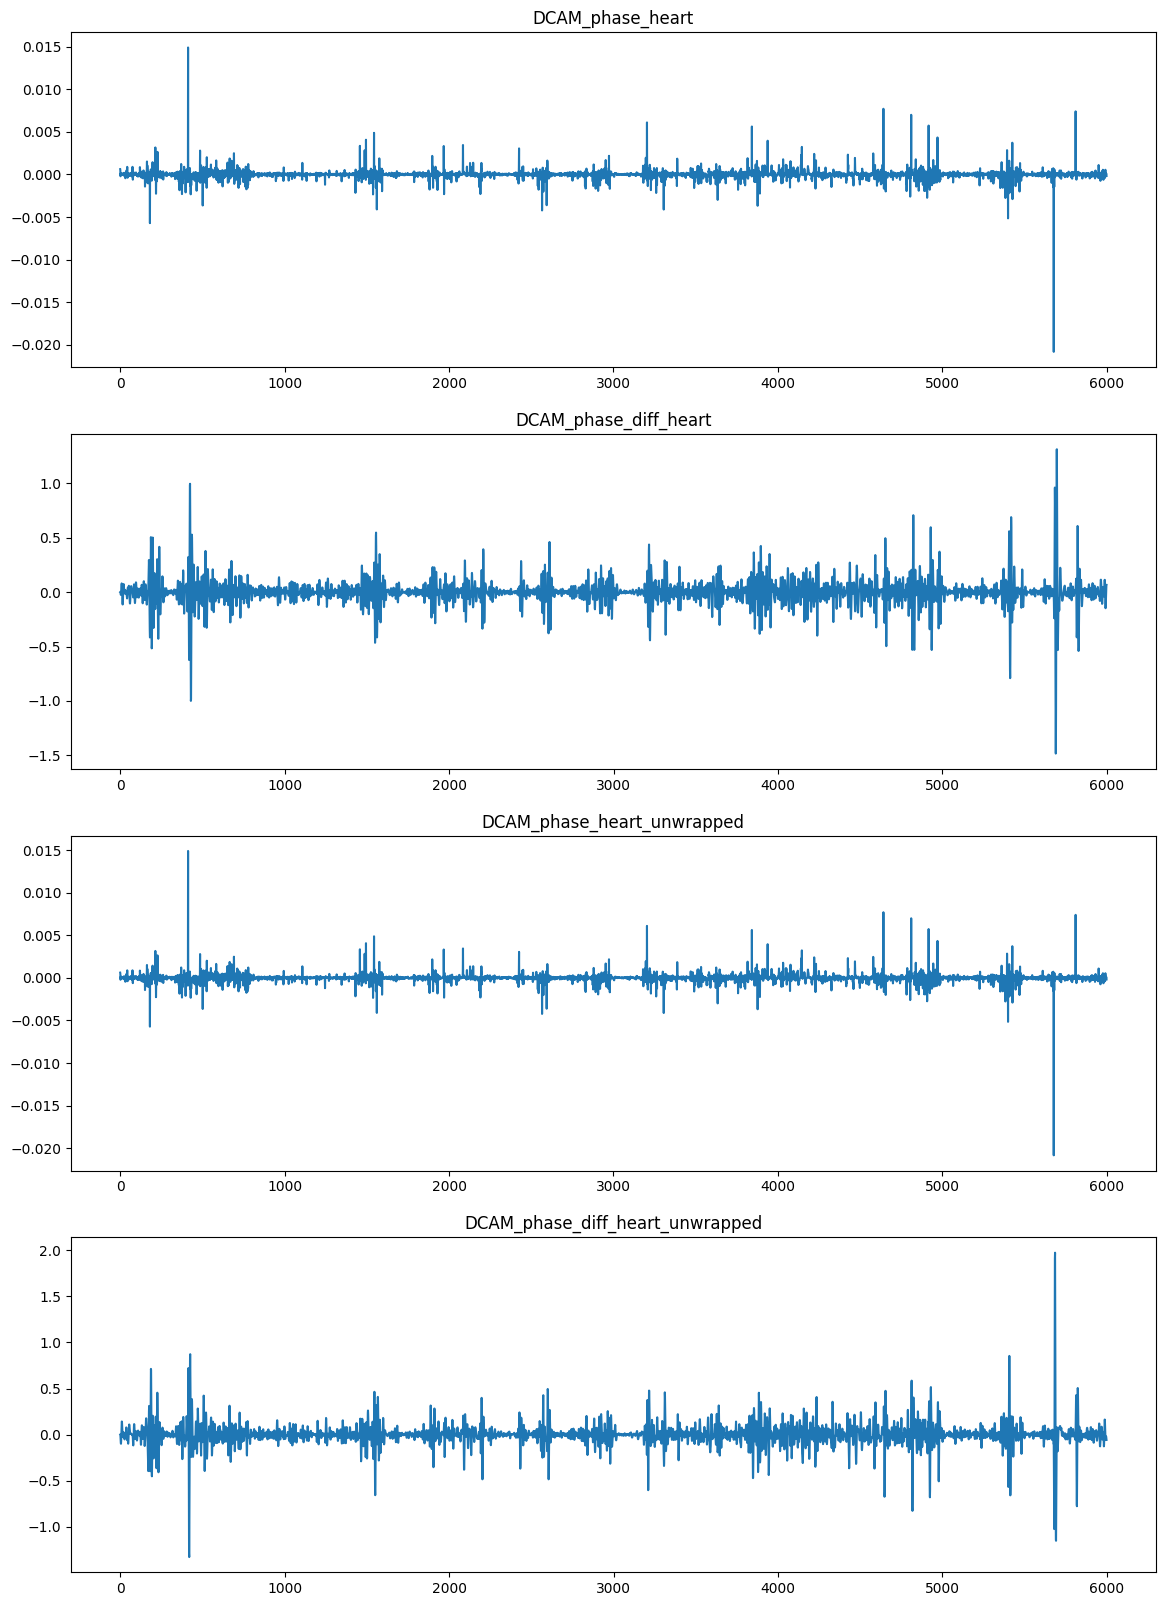

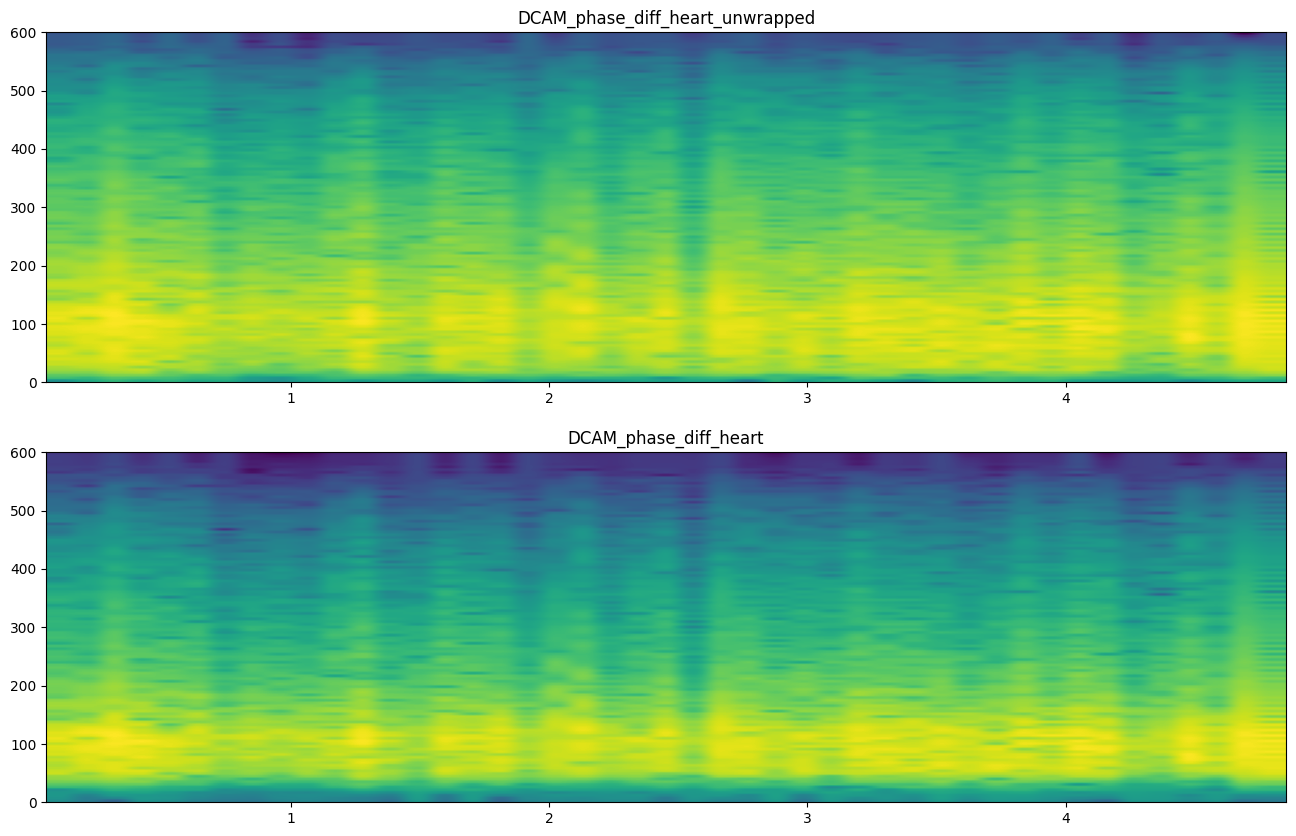

In [25]:

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 20))  # 1 row, 2 columns
axes[0].set_title("DCAM_phase_heart")
axes[0].plot(DCAM_phase_heart,label ='DCAM_phase_heart')

axes[1].set_title("DCAM_phase_diff_heart")
axes[1].plot(DCAM_phase_diff_heart,label ='DCAM_phase_diff_heart')

axes[2].set_title("DCAM_phase_heart_unwrapped")
axes[2].plot(DCAM_phase_heart_unwrapped,label ='DCAM_phase_heart_unwrapped')

axes[3].set_title("DCAM_phase_diff_heart_unwrapped")
axes[3].plot(DCAM_phase_diff_heart_unwrapped,label ='DCAM_phase_diff_heart_unwrapped')

plt.show()

plt.figure(figsize=(16, 10))
plt.subplot(211)
plt.specgram(DCAM_phase_diff_heart_unwrapped,Fs=1200)
plt.title("DCAM_phase_diff_heart_unwrapped")
plt.subplot(212)
plt.specgram(DCAM_phase_diff_heart,Fs=1200)
plt.title("DCAM_phase_diff_heart")
plt.show()


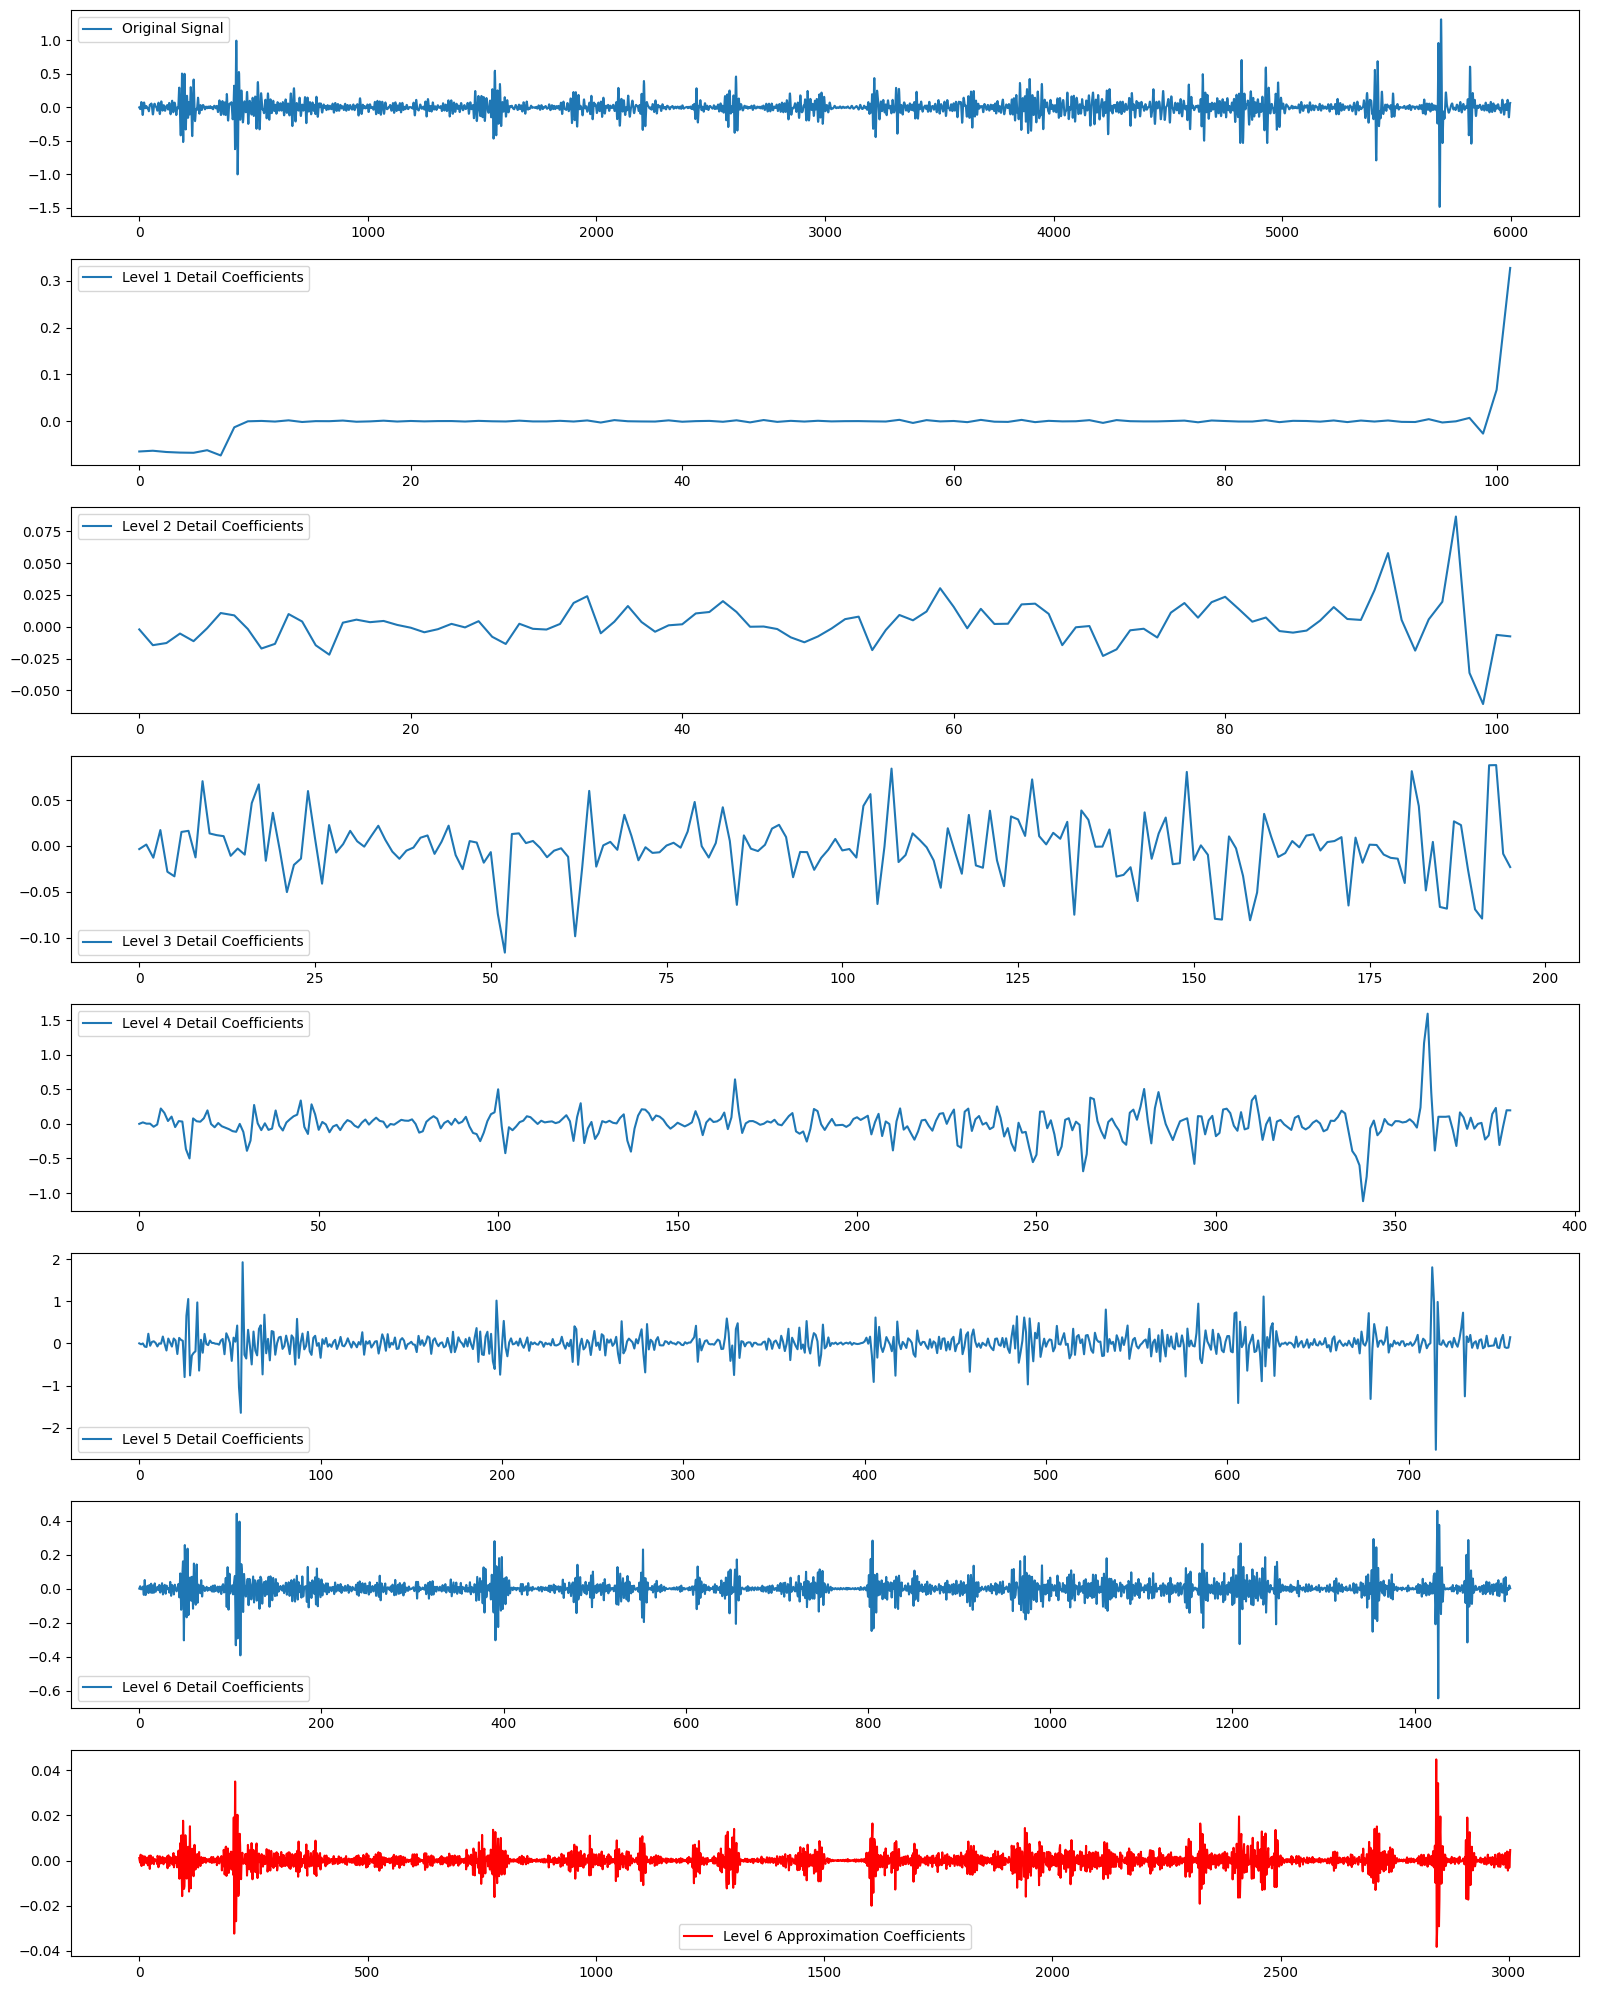

In [21]:
wavelet = 'db5'
level = 6
# Perform the DWT
coeffs = pywt.wavedec(DCAM_phase_diff_heart, wavelet, level=level)
plt.figure(figsize=(16, 20))

plt.subplot(level + 2, 1, 1)
plt.plot(DCAM_phase_diff_heart, label='Original Signal')
plt.legend()

for i in range(1, level + 1):
    plt.subplot(level + 2, 1, i + 1)
    plt.plot(coeffs[i - 1], label=f'Level {i} Detail Coefficients')
    plt.legend()

plt.subplot(level + 2, 1, level + 2)
plt.plot(coeffs[level], label=f'Level {level} Approximation Coefficients', color='red')
plt.legend()

plt.tight_layout()
plt.show()

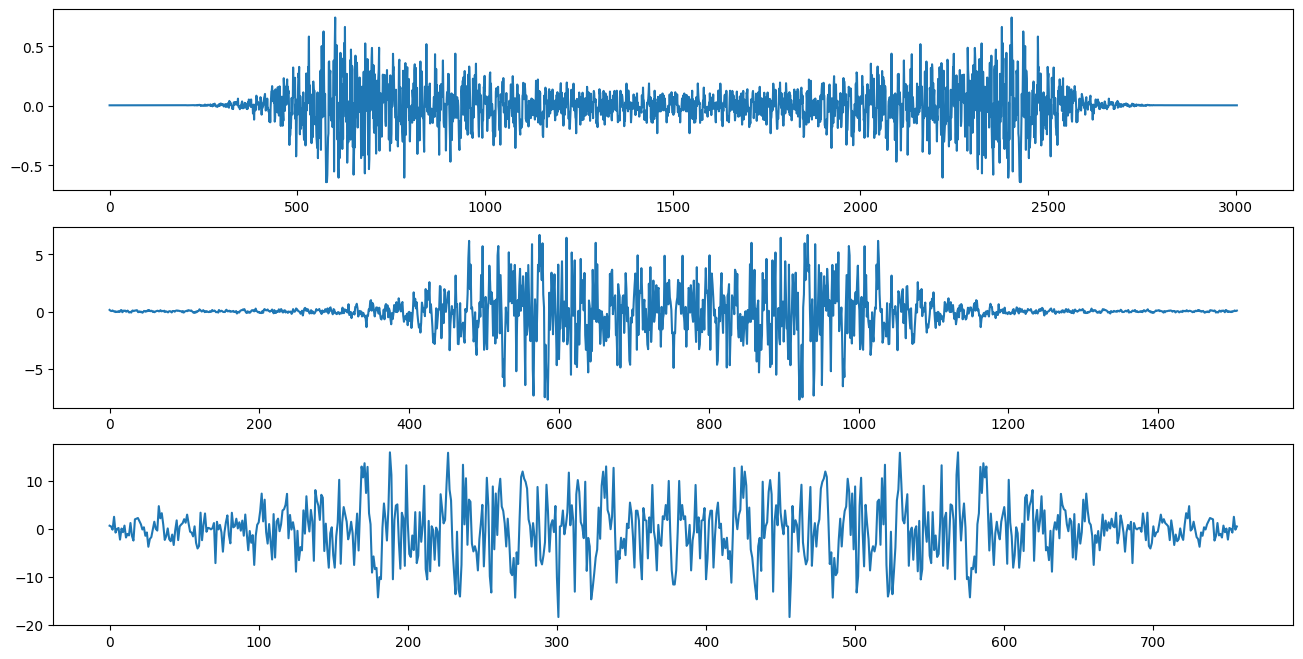

In [22]:
plt.figure(figsize=(16,8))
plt.subplot(311)
# plt.specgram(coeffs[6],Fs=600)
plt.plot(np.fft.fft(coeffs[6]))
plt.subplot(312)
# plt.specgram(coeffs[5],Fs=300)
plt.plot(np.fft.fft(coeffs[5]))
plt.subplot(313)
# plt.specgram(coeffs[4],Fs=150)
plt.plot(np.fft.fft(coeffs[4]))

plt.show()